In [1]:
import os
directory = f'/Users/lilimatic/greenspace'
os.chdir(directory)

from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
#from scipy.stats import randint

from sklearn.model_selection import RandomizedSearchCV


from sklearn.model_selection import train_test_split, cross_val_score  
from sklearn.utils.class_weight import compute_sample_weight
from sklearn import tree
from sklearn.metrics import roc_curve, roc_auc_score, classification_report, confusion_matrix, accuracy_score 

import matplotlib.pyplot as plt

import random

/Users/lilimatic/opt/anaconda3/lib/python3.8/site-packages/pandas/core/computation/expressions.py:20: UserWarning: Pandas requires version '2.7.3' or newer of 'numexpr' (version '2.7.1' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED


In [2]:
from functions.ml_data_hot_one import *

df_copy = df.copy()

/Users/lilimatic/greenspace/functions/ml_data_hot_one.py:50: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.safety[df[df.physicalsafety != df.covidsafety].index] = 0


In [3]:
sum(df.safety)/len(df.safety)

0.45

In [4]:
y = 'safety'

X_train, X_test, y_train, y_test = train_test_split(df_copy.loc[:, df_copy.columns != y], \
                                                    df_copy[y], test_size=0.25)

In [5]:
#Similar proportions
sum(y_test)/len(y_test)

0.45

In [6]:
sample_weights = compute_sample_weight(
    class_weight='balanced',
    y=y_train #provide your own target name
)

## Classification 

### XGB

In [7]:
#Hyperparameter tuning with cross-validation 

#XGB 

param_dist = {
    'max_depth': [random.randint(3, 10)],
    'learning_rate': [random.uniform(0.01, 0.1)],
    'subsample': [random.uniform(0.5, 0.5)],
    'n_estimators':[random.randint(50, 200)]
}


xgb_model = XGBClassifier(objective='binary:logistic')
random_search = RandomizedSearchCV(xgb_model, param_distributions=param_dist, n_iter=100, cv=5,scoring='roc_auc')

random_search.fit(X_train, y_train)

print("Best set of hyperparameters: ", random_search.best_params_)
print("Best score: ", random_search.best_score_)

/Users/lilimatic/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_search.py:307: UserWarning: The total space of parameters 1 is smaller than n_iter=100. Running 1 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Best set of hyperparameters:  {'subsample': 0.5, 'n_estimators': 86, 'max_depth': 8, 'learning_rate': 0.07952425425036547}
Best score:  0.7387205387205387


In [8]:
xgb = XGBClassifier(**random_search.best_params_,objective='binary:logistic')
xgb.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.07952425425036547,
              max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=8, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=86, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

### Random Forest

In [9]:
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 10, stop = 80, num = 10)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [2,4]
# Minimum number of samples required to split a node
min_samples_split = [2, 5]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2]
# Method of selecting samples for training each tree
bootstrap = [True, False]

# Create the param grid
param_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}

In [10]:
rf_Model = RandomForestClassifier()

rf_RandomGrid = RandomizedSearchCV(estimator = rf_Model, param_distributions = param_grid, n_iter=100, cv=5,scoring='roc_auc')

In [11]:
rf_RandomGrid.fit(X_train, y_train)

print("Best set of hyperparameters: ", rf_RandomGrid.best_params_)
print("Best score: ", rf_RandomGrid.best_score_)

Best set of hyperparameters:  {'n_estimators': 80, 'min_samples_split': 2, 'min_samples_leaf': 2, 'max_features': 'sqrt', 'max_depth': 4, 'bootstrap': True}
Best score:  0.75331088664422


/Users/lilimatic/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:425: FitFailedWarning: 
225 fits failed out of a total of 500.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
225 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/lilimatic/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/lilimatic/opt/anaconda3/lib/python3.8/site-packages/sklearn/base.py", line 1145, in wrapper
    estimator._validate_params()
  File "/Users/lilimatic/opt/anaconda3/lib/python3.8/site-packages/sklearn/base.py", line 638, in _validate_params
    validate_paramet

In [12]:
rf = RandomForestClassifier(**rf_RandomGrid.best_params_)

In [13]:
#Model fit 

rf.fit(X_train, y_train)


RandomForestClassifier(max_depth=4, min_samples_leaf=2, n_estimators=80)

In [14]:
print('Training accuracy: ', round(rf.score(X_train,y_train)*100,2))
print('Test accuracy:', round(rf.score(X_test,y_test)*100,2))

Training accuracy:  81.33
Test accuracy: 69.0


In [15]:
print('Training accuracy: ',xgb.score(X_train,y_train)*100) 
print ('Test accuracy:', xgb.score(X_test,y_test)*100)

Training accuracy:  94.0
Test accuracy: 73.0


In [16]:
#plot_confusion_matrix(model,X_test,y_test,values_format='d',display_labels=['Safe','Unsafe'])

In [17]:
pred_prob1 = xgb.predict_proba(X_test)
pred_prob3 = rf.predict_proba(X_test)

In [18]:
fpr1, tpr1, thresh1 = roc_curve(y_test, pred_prob1[:,1], pos_label=1)
fpr3, tpr3, thresh3 = roc_curve(y_test, pred_prob3[:,1], pos_label=1)

In [19]:
random_probs = [0 for i in range(len(y_test))]
p_fpr, p_tpr, _ = roc_curve(y_test, random_probs, pos_label=1)

In [20]:
# auc scores

auc_score1 = roc_auc_score(y_test, pred_prob1[:,1])
auc_score3 = roc_auc_score(y_test, pred_prob3[:,1])

print(auc_score1, auc_score3)

0.7559595959595959 0.7571717171717172


<ipython-input-21-2a62b5b9b880>:1: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn')


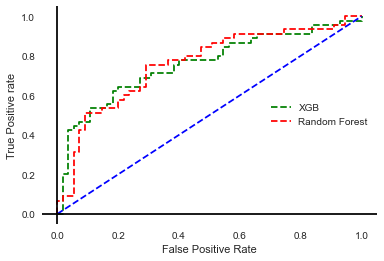

In [21]:


plt.style.use('seaborn')
plt.axes(facecolor='white')
# plot roc curves
plt.plot(fpr1, tpr1, linestyle='--',color='green',label='XGB') #XGB
plt.plot(fpr3, tpr3, linestyle='--',color='red',label='Random Forest') #label='Random Forest'
plt.plot(p_fpr, p_tpr, linestyle='--', color='blue')

#plt.title('ROC curve')
# x label
plt.xlabel('False Positive Rate')
# y label
plt.ylabel('True Positive rate')
plt.grid(False)

plt.axhline(0, color='black')
plt.axvline(0, color='black')

#ax = fig.add_axes([1,1,0,0])

#ax.set_facecolor("white")

plt.legend(loc='best')
plt.savefig('ROC',dpi=300)
#plt.show();

plt.savefig(f'/Users/lilimatic/greenspace/images/machine learning/auc_curve.png',dpi=300)


In [22]:
#rf.score(X_test,y_test)

xgb.score(X_test,y_test)

0.73

In [23]:
y_pred = xgb.predict(X_test)

In [24]:
cm = confusion_matrix(y_test,y_pred)

cm

array([[45, 10],
       [17, 28]])

In [25]:
xgb.feature_importances_

array([0.03384408, 0.02901612, 0.03351982, 0.        , 0.02878098,
       0.        , 0.02676816, 0.        , 0.02765849, 0.0289394 ,
       0.02250149, 0.03334983, 0.02834297, 0.02614956, 0.05586908,
       0.10380287, 0.02767995, 0.02138914, 0.        , 0.02525701,
       0.02685367, 0.04300066, 0.04000255, 0.        , 0.02869925,
       0.02679409, 0.03153853, 0.03164804, 0.03126201, 0.02153649,
       0.0309389 , 0.04540861, 0.0304643 , 0.03289001, 0.02609396],
      dtype=float32)

In [26]:
accuracy_score(y_pred ,y_test)

0.73

In [27]:
cross_val_score(xgb, X_train,y_train,cv=5)

array([0.68333333, 0.68333333, 0.68333333, 0.63333333, 0.68333333])

In [28]:

print(classification_report(y_pred, y_test))

              precision    recall  f1-score   support

           0       0.82      0.73      0.77        62
           1       0.62      0.74      0.67        38

    accuracy                           0.73       100
   macro avg       0.72      0.73      0.72       100
weighted avg       0.74      0.73      0.73       100



In [29]:
features = df.columns

importances = xgb.feature_importances_
indices = np.argsort(importances)

values = list(xgb.feature_importances_[indices])

names = [features[i] for i in indices]

importance = pd.DataFrame({'district' : names, 'importance': values})

importance = importance.sort_values('district')

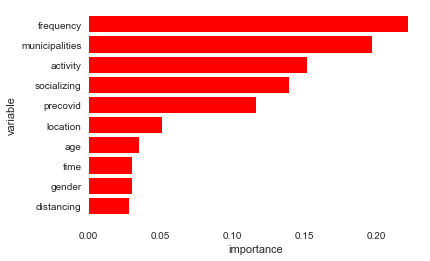

In [30]:
#merged will be summed 
merged = [] 
names_merged=[] 
for o in oldcolumns:
    if (len([col for col in df if col.startswith(o+'_')])>0):
        merged.append([col for col in df if col.startswith(o+'_')])
        names_merged.append(o)


sums_merged = []

for m in merged:
    #print(m)
    sums_merged.append(importance.loc[importance['district'].isin(m)].sum()[1])

names_merged.extend(['municipalities','activity','socializing','age','time'])

for x in [list_municipalities,list_activities,list_socializing]: 
    sums_merged.append(importance.loc[importance['district'].isin(list(x.columns))].sum()[1])
    
sums_merged.extend([importance.loc[importance['district'].isin(['age'])]['importance'].iloc[0],
importance.loc[importance['district'].isin(['time'])]['importance'].iloc[0]])

#remove effect of safety variable
sums_merged= sums_merged/sum(sums_merged)

important = pd.DataFrame({'variable': names_merged,'importance':sums_merged })

important = important.sort_values('importance')

#important.plot.bar(x='variable',y='importance',rot=0)

plt.axes(facecolor='white')
plt.barh(important.variable,important.importance,color='red')
plt.grid(False)
plt.xlabel('importance')
plt.ylabel('variable')

#ax.set_facecolor('white')

plt.savefig(f'/Users/lilimatic/greenspace/images/machine learning/importance_rf.png',transparent=True,dpi=300)


In [31]:
important = important.sort_values('importance')
round(important,2)

,variable,importance
3,distancing,0.03
0,gender,0.03
9,time,0.03
8,age,0.04
4,location,0.05
1,precovid,0.12
7,socializing,0.14
6,activity,0.15
5,municipalities,0.20
2,frequency,0.22


In [32]:
features = df.columns

importances = xgb.feature_importances_
indices = np.argsort(importances)

values = list(xgb.feature_importances_[indices])

names = [features[i] for i in indices]

importance = pd.DataFrame({'district' : names, 'importance': values})

importance = importance.sort_values('district')

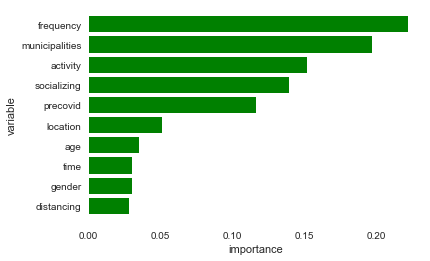

In [33]:
#merged will be summed 
merged = [] 
names_merged=[] 
for o in oldcolumns:
    if (len([col for col in df if col.startswith(o+'_')])>0):
        merged.append([col for col in df if col.startswith(o+'_')])
        names_merged.append(o)


sums_merged = []

for m in merged:
    #print(m)
    sums_merged.append(importance.loc[importance['district'].isin(m)].sum()[1])

names_merged.extend(['municipalities','activity','socializing','age','time'])

for x in [list_municipalities,list_activities,list_socializing]: 
    sums_merged.append(importance.loc[importance['district'].isin(list(x.columns))].sum()[1])
    
sums_merged.extend([importance.loc[importance['district'].isin(['age'])]['importance'].iloc[0],
importance.loc[importance['district'].isin(['time'])]['importance'].iloc[0]])

#remove effect of safety variable
sums_merged= sums_merged/sum(sums_merged)

important = pd.DataFrame({'variable': names_merged,'importance':sums_merged })

important = important.sort_values('importance')

#important.plot.bar(x='variable',y='importance',rot=0)

plt.axes(facecolor='white')
plt.barh(important.variable,important.importance,color='green')
plt.grid(False)
plt.xlabel('importance')
plt.ylabel('variable')

#ax.set_facecolor('white')

plt.savefig(f'/Users/lilimatic/greenspace/images/machine learning/importance_xgb.png',transparent=True,dpi=300)

In [34]:
round(important,2)

,variable,importance
3,distancing,0.03
0,gender,0.03
9,time,0.03
8,age,0.04
4,location,0.05
1,precovid,0.12
7,socializing,0.14
6,activity,0.15
5,municipalities,0.20
2,frequency,0.22


In [35]:
fn=X_train.columns
cn=['safe','not safe']

In [36]:
cn

['safe', 'not safe']

In [37]:
fig, axes = plt.subplots(nrows = 1,ncols = 1,figsize = (15,10), dpi=900)

tree.plot_tree(rf.estimators_[1],
               feature_names = fn, 
               class_names=cn,
               max_depth =2,
               filled = True, fontsize=10);
plt.savefig(f'/Users/lilimatic/greenspace/images/machine learning/rf_individualtree.png',dpi=300)

